# Inception model explanations, t1

## First we need dataframes for every subject

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import utils
import keras

%matplotlib inline

# DEFINE GRAPH
from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

Using TensorFlow backend.


In [3]:
# Data paths
rgb_path = '../data/jpg_320_180_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 320
input_height = 180
seq_length = 10
seq_stride = 1
batch_size = 10
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

nb_input_dims = 4

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [4]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light, nb_input_dims)

In [5]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light,
                         nb_input_dims=args.nb_input_dims)

In [6]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/


## Now that we have frames from all subjects, we can load the model we want to test.

In [10]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_inception_4d_input_from_scratch_rmsprop_LSTMunits_None_CONVfilters_None_dense512_320x180jpg2fps_bs100_rmsprop_all_aug_v4_t1_run1_gc_rerun.h5'


In [11]:
from keras import backend as K
import tensorflow as tf

tf.reset_default_graph()
K.clear_session()
    
images = tf.placeholder(tf.float32, [batch_size, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, 2])

model = utils.InceptionNetwork(images, from_scratch=0, path=best_model_path)

Loading model...
Finished loading model. Building layers...


In [12]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

print('model preds: ', model.preds)

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)

print('cost: ', cost)

y_c = tf.reduce_sum(tf.multiply(model.dense_2, labels), axis=1)

print('y_c: ', y_c)


target_conv_layer = model.c_86  # Choose which layer to study
# target_conv_layer = model.c_94  # Here: last conv.
# target_conv_layer = model.mixed10 

print('TYPE tcl: ', type(target_conv_layer))
print('tcl: ', target_conv_layer)

target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tcl grad: ', target_conv_layer_grad)
print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_95_1/Sigmoid:0", shape=(10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(10,), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(10,), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tcl:  Tensor("conv2d_86_1/convolution:0", shape=(10, 8, 4, 320), dtype=float32)
tcl grad:  Tensor("gradients/AddN:0", shape=(10, 8, 4, 320), dtype=float32)
tclg:  Tensor("gradients/AddN:0", shape=(10, 8, 4, 320), dtype=float32)


In [13]:
def run_on_one_sequence(sess, model, batch_img, args):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
              feed_dict={images: batch_img,
              labels: batch_label,
              K.learning_phase(): 0})
        
        utils.visualize_overlays(batch_img, target_conv_layer_value,
                                 target_conv_layer_grad_value, args)

# Inception predictions for subject 1

Chose subject  1
Start index in subject dataframe:  6371
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2a/frame_002616.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2a/frame_002617.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2a/frame_002618.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2a/frame_002619.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2a/frame_002620.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2a/frame_002621.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2a/frame_002622.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2a/frame_002623.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2a/frame_002624.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2a/frame_002625.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


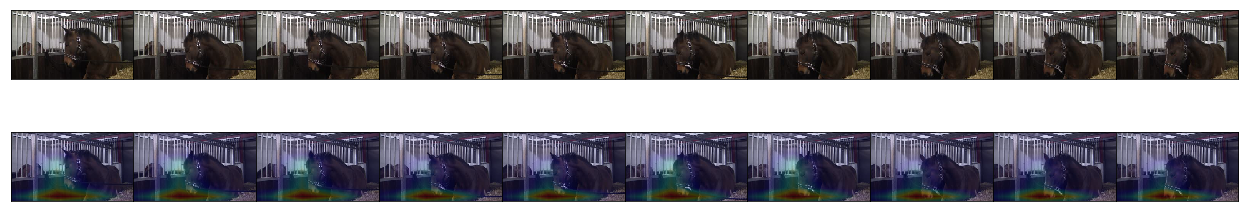

In [14]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  1510
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_1a/frame_001511.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_1a/frame_001512.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_1a/frame_001513.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_1a/frame_001514.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_1a/frame_001515.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_1a/frame_001516.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_1a/frame_001517.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_1a/frame_001518.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_1a/frame_001519.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_1a/frame_001520.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


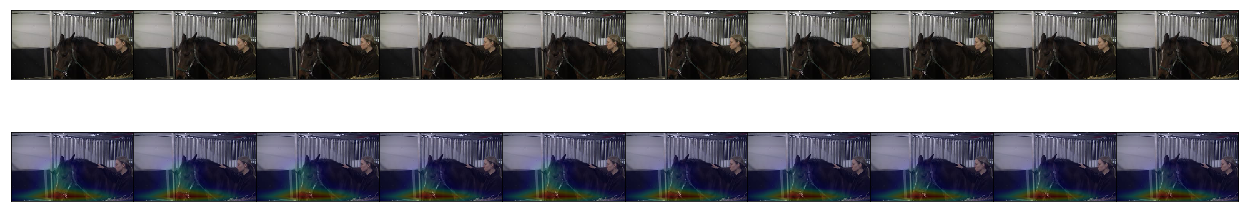

In [15]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  1983
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_1a/frame_001984.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_1a/frame_001985.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_1a/frame_001986.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_1a/frame_001987.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_1a/frame_001988.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_1a/frame_001989.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_1a/frame_001990.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_1a/frame_001991.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_1a/frame_001992.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_1a/frame_001993.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


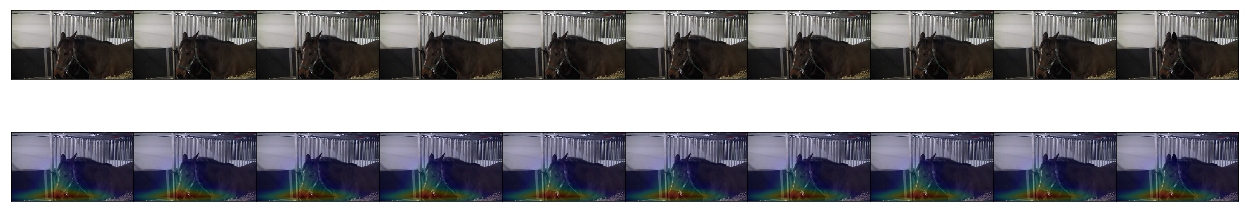

In [16]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  9959
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000902.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000903.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000904.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000905.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000906.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000907.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000908.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000909.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000910.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000911.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


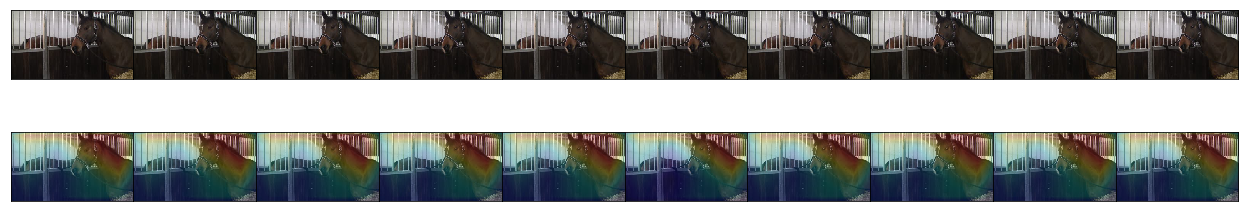

In [17]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  4416
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2a/frame_000661.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2a/frame_000662.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2a/frame_000663.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2a/frame_000664.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2a/frame_000665.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2a/frame_000666.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2a/frame_000667.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2a/frame_000668.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2a/frame_000669.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2a/frame_000670.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


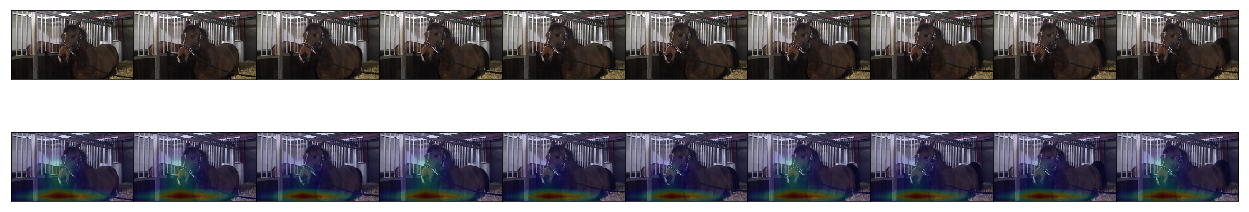

In [18]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  11571
                                                 Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_4/frame_000894.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_4/frame_000895.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_4/frame_000896.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_4/frame_000897.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_4/frame_000898.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_4/frame_000899.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_4/frame_000900.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_4/frame_000901.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_4/frame_000902.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_4/frame_000903.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


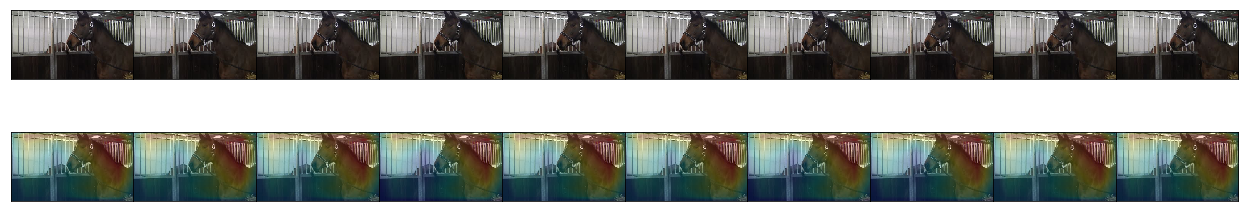

In [19]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  6313
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2a/frame_002558.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2a/frame_002559.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2a/frame_002560.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2a/frame_002561.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2a/frame_002562.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2a/frame_002563.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2a/frame_002564.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2a/frame_002565.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2a/frame_002566.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2a/frame_002567.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


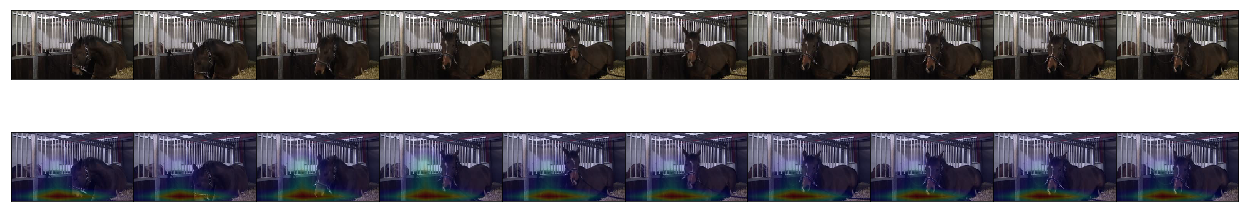

In [20]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  3225
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_1b/frame_000560.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_1b/frame_000561.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_1b/frame_000562.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_1b/frame_000563.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_1b/frame_000564.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_1b/frame_000565.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_1b/frame_000566.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_1b/frame_000567.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_1b/frame_000568.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_1b/frame_000569.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


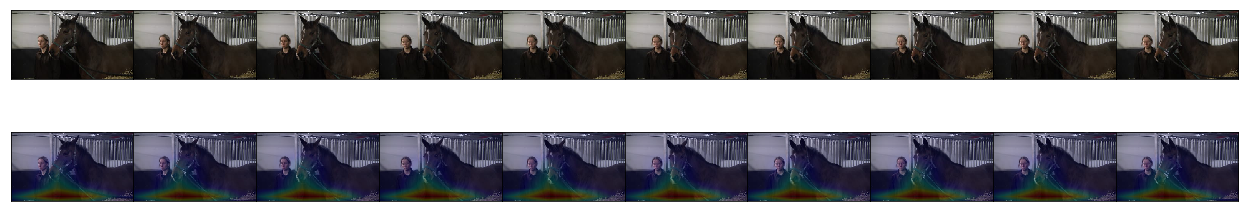

In [21]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  175
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_1a/frame_000176.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_1a/frame_000177.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_1a/frame_000178.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_1a/frame_000179.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_1a/frame_000180.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_1a/frame_000181.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_1a/frame_000182.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_1a/frame_000183.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_1a/frame_000184.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_1a/frame_000185.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


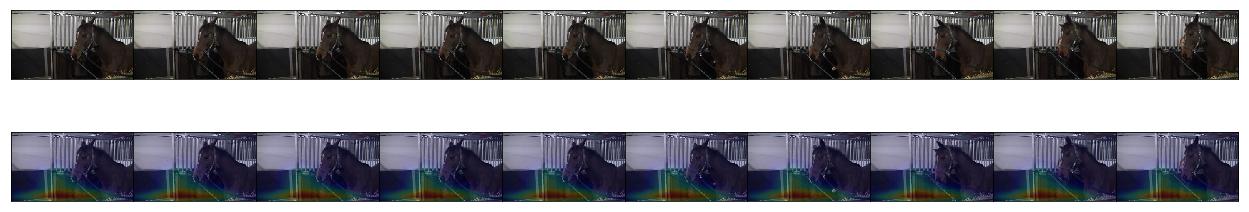

In [22]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  214
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_1a/frame_000215.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_1a/frame_000216.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_1a/frame_000217.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_1a/frame_000218.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_1a/frame_000219.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_1a/frame_000220.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_1a/frame_000221.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_1a/frame_000222.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_1a/frame_000223.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_1a/frame_000224.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


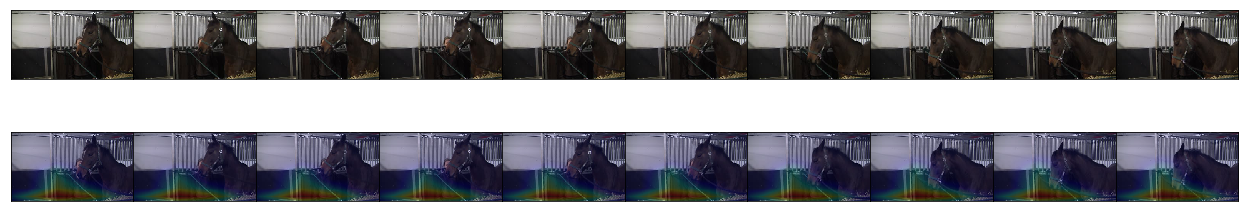

In [23]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  4017
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2a/frame_000262.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2a/frame_000263.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2a/frame_000264.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2a/frame_000265.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2a/frame_000266.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2a/frame_000267.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2a/frame_000268.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2a/frame_000269.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2a/frame_000270.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2a/frame_000271.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


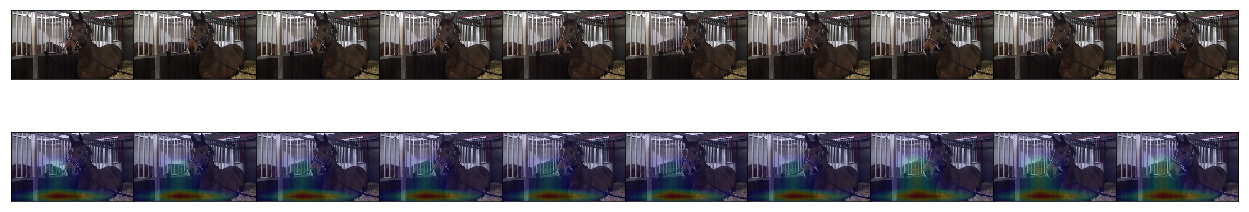

In [24]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  8047
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000670.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000671.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000672.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000673.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000674.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000675.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000676.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000677.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000678.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000679.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


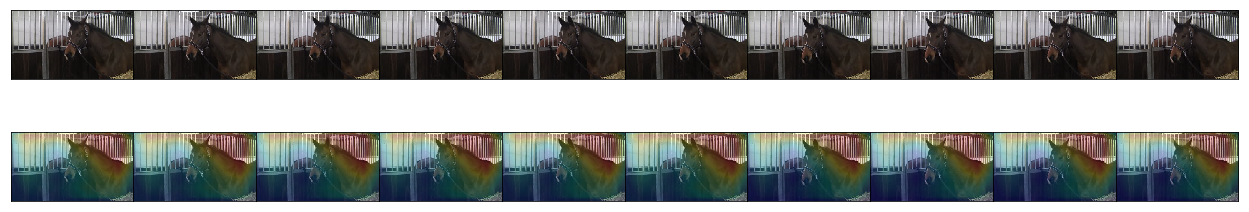

In [25]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  0
Start index in subject dataframe:  8547
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001294.jpg     1
1  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001295.jpg     1
2  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001296.jpg     1
3  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001297.jpg     1
4  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001298.jpg     1
5  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001299.jpg     1
6  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001300.jpg     1
7  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001301.jpg     1
8  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001302.jpg     1
9  data/jpg_320_180_2fps/horse_1/1_3a_1/frame_001303.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


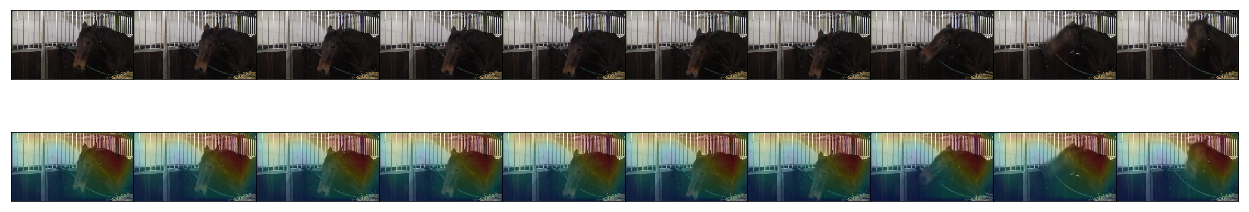

In [26]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=0)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  2
Start index in subject dataframe:  7767
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_3/3_3a/frame_000428.jpg     1
1  data/jpg_320_180_2fps/horse_3/3_3a/frame_000429.jpg     1
2  data/jpg_320_180_2fps/horse_3/3_3a/frame_000430.jpg     1
3  data/jpg_320_180_2fps/horse_3/3_3a/frame_000431.jpg     1
4  data/jpg_320_180_2fps/horse_3/3_3a/frame_000432.jpg     1
5  data/jpg_320_180_2fps/horse_3/3_3a/frame_000433.jpg     1
6  data/jpg_320_180_2fps/horse_3/3_3a/frame_000434.jpg     1
7  data/jpg_320_180_2fps/horse_3/3_3a/frame_000435.jpg     1
8  data/jpg_320_180_2fps/horse_3/3_3a/frame_000436.jpg     1
9  data/jpg_320_180_2fps/horse_3/3_3a/frame_000437.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


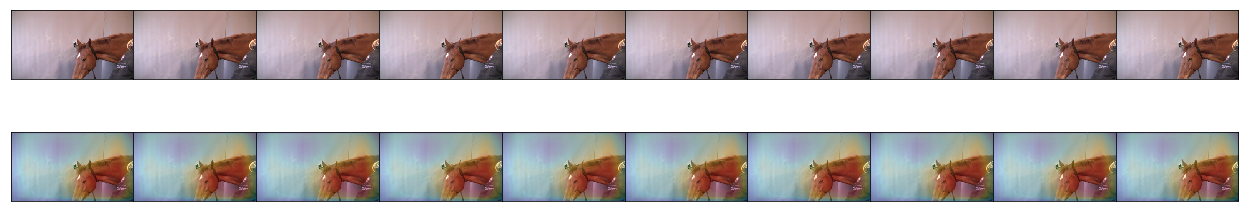

In [27]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=2)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  3
Start index in subject dataframe:  11634
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_3a/frame_000691.jpg     1
1  data/jpg_320_180_2fps/horse_4/4_3a/frame_000692.jpg     1
2  data/jpg_320_180_2fps/horse_4/4_3a/frame_000693.jpg     1
3  data/jpg_320_180_2fps/horse_4/4_3a/frame_000694.jpg     1
4  data/jpg_320_180_2fps/horse_4/4_3a/frame_000695.jpg     1
5  data/jpg_320_180_2fps/horse_4/4_3a/frame_000696.jpg     1
6  data/jpg_320_180_2fps/horse_4/4_3a/frame_000697.jpg     1
7  data/jpg_320_180_2fps/horse_4/4_3a/frame_000698.jpg     1
8  data/jpg_320_180_2fps/horse_4/4_3a/frame_000699.jpg     1
9  data/jpg_320_180_2fps/horse_4/4_3a/frame_000700.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


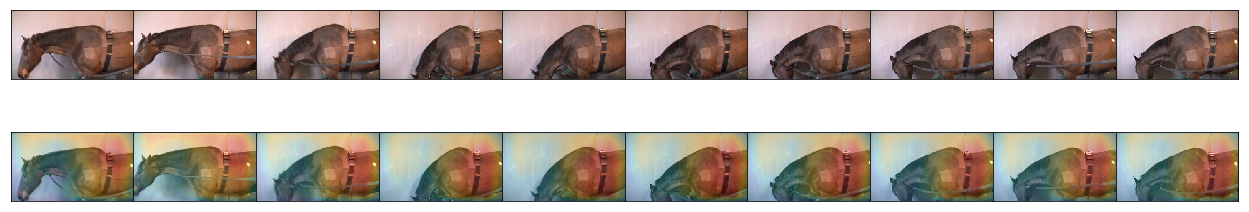

In [28]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  4
Start index in subject dataframe:  2463
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_5/5_1b/frame_000442.jpg     0
1  data/jpg_320_180_2fps/horse_5/5_1b/frame_000443.jpg     0
2  data/jpg_320_180_2fps/horse_5/5_1b/frame_000444.jpg     0
3  data/jpg_320_180_2fps/horse_5/5_1b/frame_000445.jpg     0
4  data/jpg_320_180_2fps/horse_5/5_1b/frame_000446.jpg     0
5  data/jpg_320_180_2fps/horse_5/5_1b/frame_000447.jpg     0
6  data/jpg_320_180_2fps/horse_5/5_1b/frame_000448.jpg     0
7  data/jpg_320_180_2fps/horse_5/5_1b/frame_000449.jpg     0
8  data/jpg_320_180_2fps/horse_5/5_1b/frame_000450.jpg     0
9  data/jpg_320_180_2fps/horse_5/5_1b/frame_000451.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


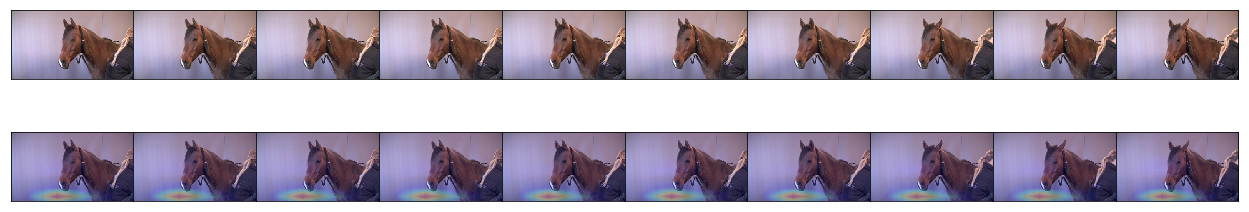

In [29]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=4)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  3170
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2b/frame_001171.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2b/frame_001172.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2b/frame_001173.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2b/frame_001174.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2b/frame_001175.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2b/frame_001176.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2b/frame_001177.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2b/frame_001178.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2b/frame_001179.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2b/frame_001180.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


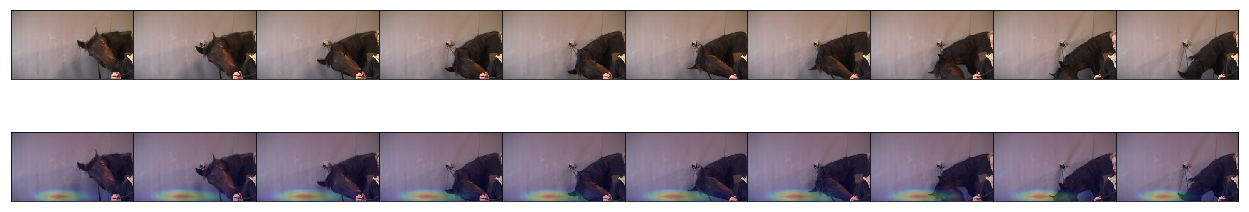

In [30]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  7039
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2b/frame_000620.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2b/frame_000621.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2b/frame_000622.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2b/frame_000623.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2b/frame_000624.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2b/frame_000625.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2b/frame_000626.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2b/frame_000627.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2b/frame_000628.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2b/frame_000629.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


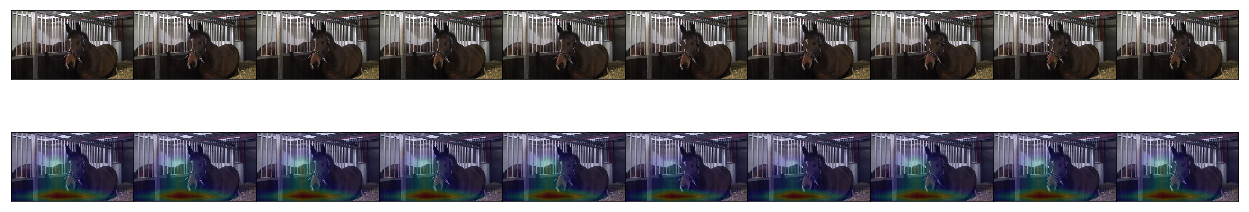

In [31]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  1648
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_001649.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_001650.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_001651.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_001652.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_001653.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_001654.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_001655.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_001656.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_001657.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_001658.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


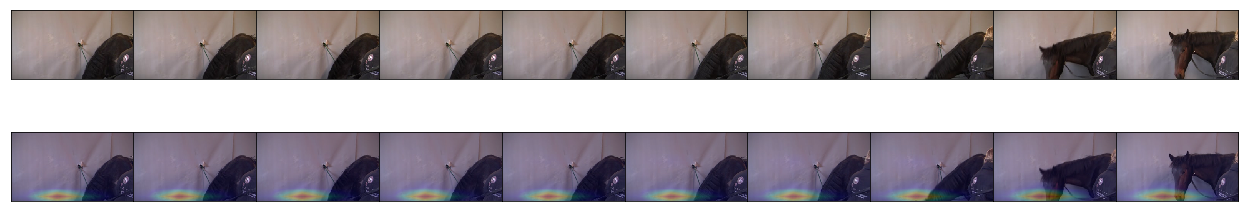

In [32]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)